In [ ]:
# %pip install pandas_datareader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import pandas_datareader as pdr

CURRENT_DATE = pd.datetime.now().date()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [111]:
# Get a pandas dataframe of stock data over a certain time period
def get_stock_data(ticker,  start_date='2015-1-1', end_date=CURRENT_DATE):
  return pdr.DataReader(
      ticker.upper(),
      start=start_date,
      end=end_date,
      data_source='yahoo',
  )

def get_stocks(tickers,  start_date='2015-1-1', end_date=CURRENT_DATE):
  dfs = []
  for t in tickers:
    dfs.append(pdr.DataReader(
      t.upper(),
      start=start_date,
      end=end_date,
      data_source='yahoo',
    ))
  return dfs

# Matt - Datadog, Twilio

                 High        Low       Open      Close   Volume  Adj Close
Date                                                                      
2019-09-20  39.200001  36.150002  38.590000  36.150002  3322600  36.150002
2019-09-23  38.150002  35.750000  36.580002  36.110001  2237300  36.110001
2019-09-24  37.119999  34.060001  36.009998  34.500000  3175000  34.500000
2019-09-25  35.599998  34.200001  34.599998  35.250000  3026600  35.250000
2019-09-26  36.290001  32.299999  36.000000  32.439999  2658200  32.439999


       Date  est_sales     px
0  10/20/19      468.2  31.57
1  10/21/19      468.3  30.01
2  10/22/19      468.3  28.04
3  10/23/19      468.3  28.76
4  10/24/19      468.3  32.50
       Date  est_sales     px
0  10/20/19      468.2  31.57
1  10/21/19      468.3  30.01
2  10/22/19      468.3  28.04
3  10/23/19      468.3  28.76
4  10/24/19      468.3  32.50
                 High        Low       Open      Close    Volume  Adj Close
Date                                                                       
2016-06-24  28.739000  26.049999  27.540001  26.299999   4667800  26.299999
2016-06-27  28.190001  26.299999  27.350000  27.250000   3907500  27.250000
2016-06-28  33.410999  29.570000  30.400000  29.920000  10608500  29.920000
2016-06-29  37.189999  31.750000  31.980000  37.080002  13783000  37.080002
2016-06-30  41.889999  34.799999  39.680000  36.500000  18512600  36.500000


       Date  est_sales      px
0  10/20/19    1486.15  106.35
1  10/21/19    1486.15  105.54
2  10/22/19    1486.15  100.65
3  10/23/19    1486.15  100.50
4  10/24/19    1486.15  105.63
       Date  est_sales      px
0  10/20/19    1486.15  106.35
1  10/21/19    1486.15  105.54
2  10/22/19    1486.15  100.65
3  10/23/19    1486.15  100.50
4  10/24/19    1486.15  105.63


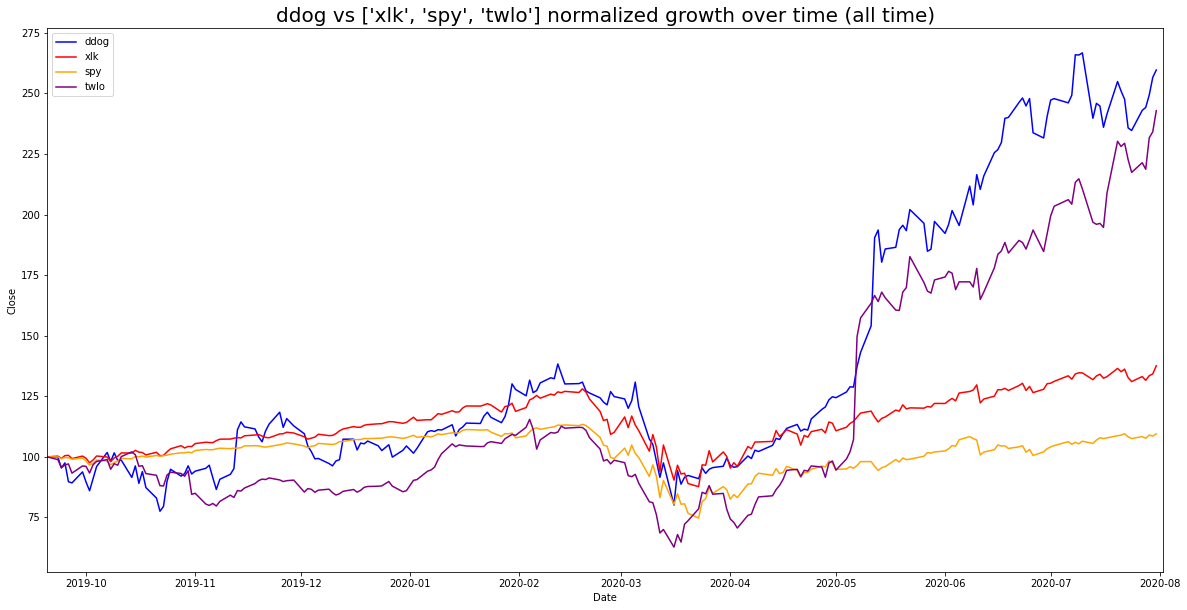

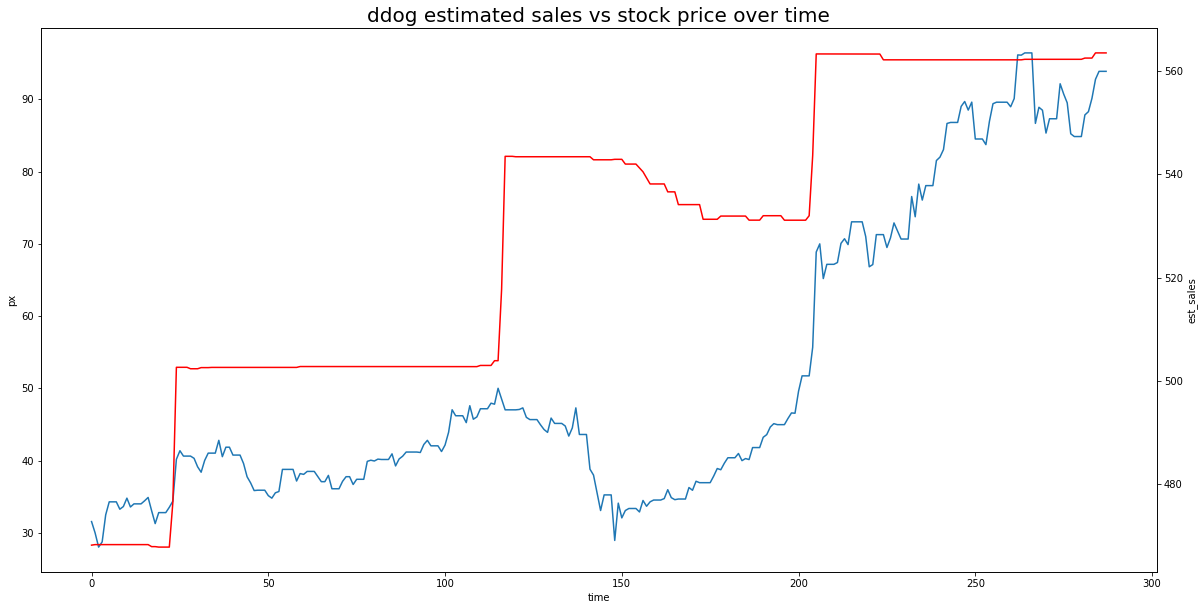

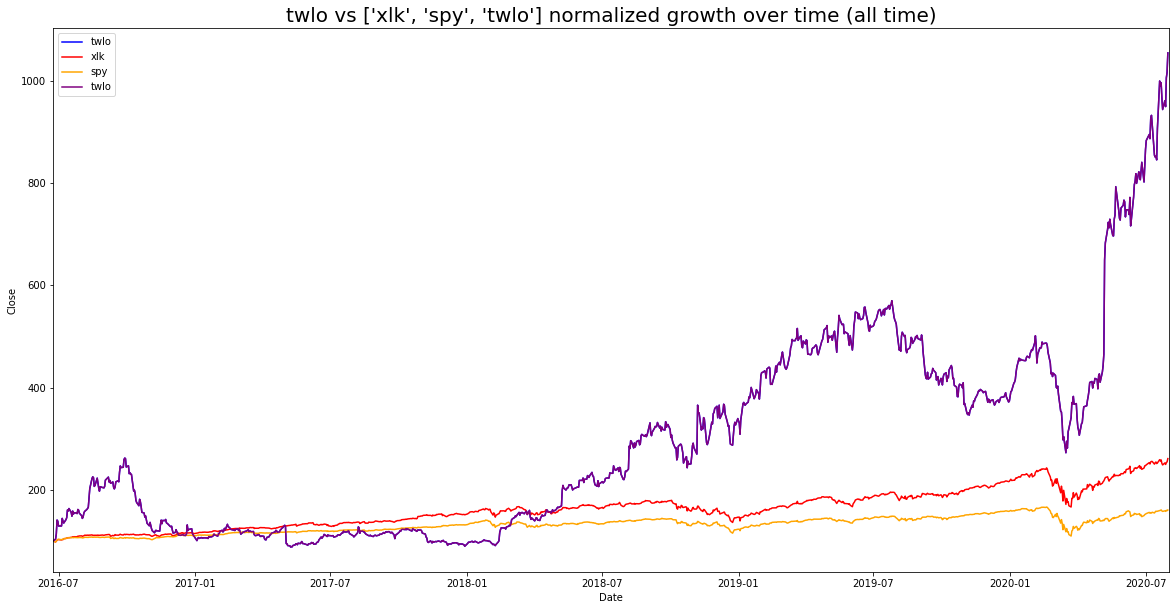

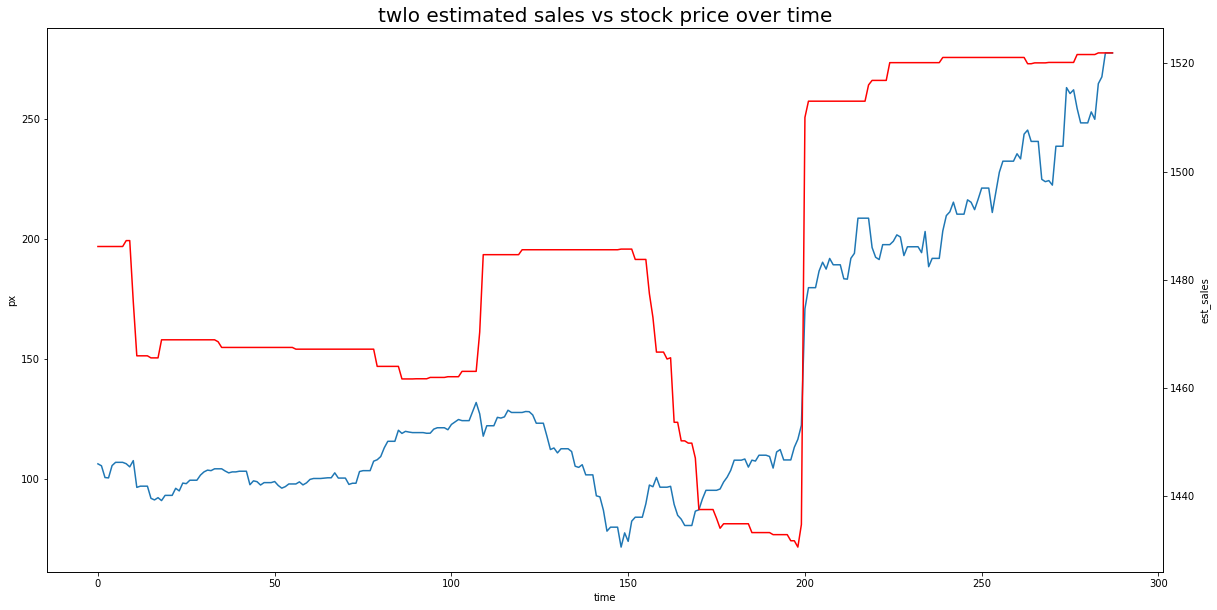

In [130]:
class Analysis:
  def __init__(self, ticker, start_date):
    self.ticker = ticker.lower()
    self.start_date = start_date
    self.df = get_stock_data(self.ticker, start_date=self.start_date)
    print(self.df.head())

    # -- CONFIG -- #
    self.comp_stocks = ['xlk', 'spy', 'twlo'] 
    self.grow_amount = 100

  def chart(self):
    self.time_series()
    self.k_growth()
    self.est_sales_v_px()
    self.p_sup_v_p_px()

  def time_series(self):
    # Basic time series
    go.Figure(data=[go.Candlestick(
        x=self.df.index,
        open=self.df['Open'],
        high=self.df['High'],
        low=self.df['Low'],
        close=self.df['Close'])]).show()

  def k_growth(self):
    # Calculate the k constants for each stock in the comp_stocks list
    main_k = self.grow_amount / self.df.loc[self.start_date, 'Close']
    dfs = get_stocks(self.comp_stocks, start_date=self.start_date)
    ks = []
    for i in range(len(self.comp_stocks)):
      ks.append(self.grow_amount / dfs[i].loc[self.start_date, 'Close'])

    # Chart it
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_xlabel('time')
    ax.set_title(
        f'{self.ticker} vs {self.comp_stocks} normalized growth over time (all time)',
        fontsize=20,
    )
    ax.set_xlim([self.df.index[0], CURRENT_DATE])
    colors = ['red', 'orange', 'purple', 'green']

    sns.lineplot(
        self.df.index,
        main_k * self.df['Close'],
        ax=ax, color='blue', label=self.ticker,
    ).set_ylabel('price * k')
    for i in range(len(ks)):
      normalized = ks[i] * dfs[i]['Close']
      sns.lineplot(
          self.df.index,
          normalized,
          ax=ax, color=colors[i], label=self.comp_stocks[i],
      )
      '''
      print(self.comp_stocks[i])
      print(normalized)
      print()
      print()

      print(self.ticker)
      print(main_k * self.df['Close'])
      '''
    ax.legend()

  # Estimated sales versus stock price daily
  def est_sales_v_px(self):
    # Data prep & cleaning
    df = pd.read_csv(f'/content/{self.ticker}_daily_est.csv')
    print(df.head())

    # Calc day over day change
    daily_est = df['est_sales'].pct_change(1)
    daily_px = df['px'].pct_change(1)

    print(df.head())

    # Plot px and rev on the same time series
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.set_title(
        f'{self.ticker} estimated sales vs stock price over time',
        fontsize=20,
    )
    ax1.set_xlabel('time')
    ax1.set_ylabel('px')
    ax1 = sns.lineplot(df.index, df['px'])
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('expected revenue')
    ax2.tick_params(axis='y')
    ax2 = sns.lineplot(df.index, df['est_sales'], color='red')

  # % surprise vs stock % change quarterly 
  def p_sup_v_p_px(self):
    # df = pd.read_csv(f'/content/{self.ticker}_sup.csv')
    pass
 
ddog = Analysis('ddog', start_date='2019-09-20')
ddog.chart()

twlo = Analysis('twlo', start_date='2016-06-24')
twlo.chart()

# Idris - Technology Select Sector SPDR Fund (XLK), ZScaler (ZS)

In [ ]:
xlk = get_stock_data('xlk', start_date='1999-1-29')
xlk.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-01-29,37.84375,36.9375,37.37500,37.812500,933600.0,29.426785
1999-02-01,38.37500,37.5625,38.15625,37.843750,913000.0,29.451113
1999-02-02,38.00000,36.6250,38.00000,37.203125,1259200.0,28.952547
1999-02-03,38.06250,36.8125,37.06250,37.468750,1334100.0,29.159277
1999-02-04,37.75000,35.8750,37.75000,36.187500,1945900.0,28.162167


Text(0.5, 1.0, 'Volume')

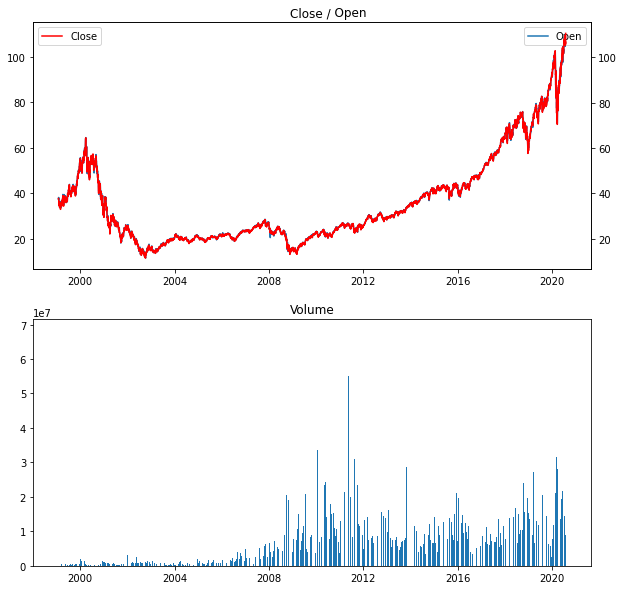

In [ ]:
fig, (ax1, ax3) = plt.subplots(2, figsize=(10,10))
ax1.set_title('                    Open')
ax1.plot(xlk.index, xlk['Open'], label='Open')
ax2 = ax1.twinx()
ax2.set_title('Close / ')
ax2.plot(xlk.index, xlk['Close'], color='red', label='Close')
ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.bar(xlk.index, 'Volume', data=xlk)
ax3.set_title('Volume')

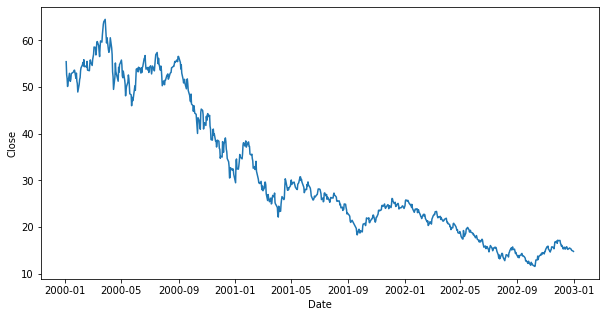

In [ ]:
xlk_drop1 = xlk.loc['2000-1-1':'2003-1-1', :]

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=xlk_drop1.index, y='Close', ax=ax, data=xlk_drop1)

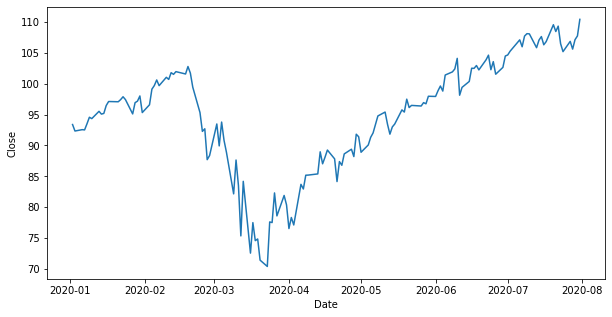

In [ ]:
xlk_drop2 = xlk.loc['2020-1-1':, :]

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=xlk_drop2.index, y='Close', ax=ax, data=xlk_drop2)

In [ ]:
zs = get_stock_data('zs', start_date='2018-3-29')

Text(0.5, 1.0, 'Volume')

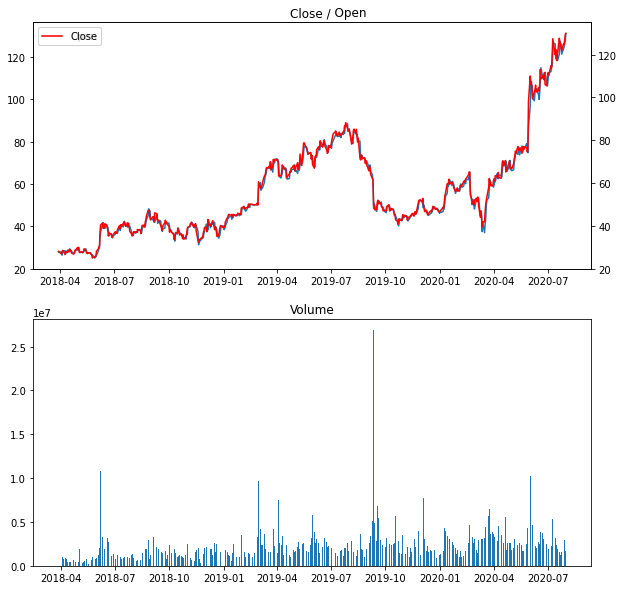

In [ ]:
fig, (ax1, ax3) = plt.subplots(2, figsize=(10,10))
ax1.set_title('                    Open')
ax1.plot(zs.index, zs['Open'], label='Open')
ax2 = ax1.twinx()
ax2.set_title('Close / ')
ax2.plot(zs.index, zs['Close'], color='red', label='Close')
ax1.legend(loc=0)
ax2.legend(loc=2)
ax3.bar(zs.index, 'Volume', data=zs)
ax3.set_title('Volume')

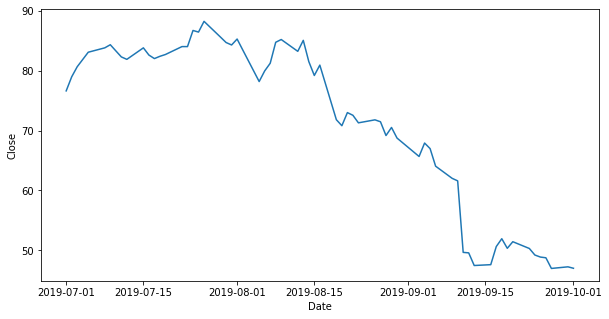

In [ ]:
zs_drop1 = zs.loc['2019-7-1':'2019-10-1', :]

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=zs_drop1.index, y='Close', ax=ax, data=zs_drop1)

# So - Moderna and Inovio 

In [ ]:
mrna = get_stock_data('mrna', start_date='2018-12-8')
ino = get_stock_data('ino', start_date='1998-12-11')

def columns_lower(ticker):  
  return map(str.lower, ticker.columns
             )

mrna.columns = columns_lower(mrna)
ino.columns = columns_lower(ino)

In [ ]:
mrna

In [ ]:
ino

[Text(0, 0.5, 'Adjusted Close Price'), Text(0.5, 0, 'Date')]

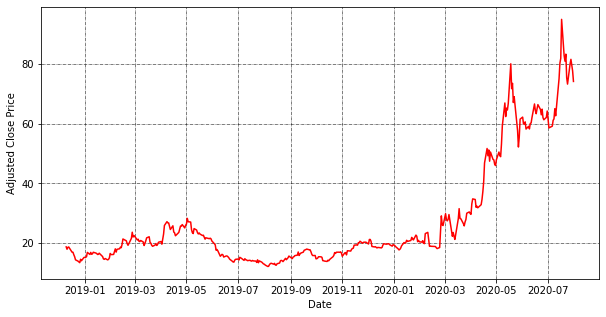

In [ ]:
fig_dims = (10, 5)
fig, ax1 = plt.subplots(figsize=fig_dims)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)


ax1 = sns.lineplot(x=mrna.index, y='adj close', data = mrna, color='red', legend="full")

ax1.set(xlabel='Date', ylabel='Adjusted Close Price')

#ax2 = ax1.twinx()
#ax2 = sns.lineplot(x=mrna.index, y='volume', data = mrna)

#ax1.set_label('Adjusted Close Price')



In [ ]:
#mrna[['adj close']].plot(subplots=False,figsize=(15,10))
#mrna[['volume']].plot(subplots=False,figsize=(15,10))

In [ ]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    
    mrna[column_name] = mrna['adj close'].rolling(window=ma,center=False).mean()

mrna.tail()

,high,low,open,close,volume,adj close,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,,,
2020-07-27,80.980003,76.160004,80.629997,79.910004,44710700,79.910004,80.7135,71.73775,66.6243
2020-07-28,83.849998,79.500000,81.000000,81.489998,32946900,81.489998,81.3585,72.70825,66.9203
2020-07-29,82.820000,76.550003,81.980003,79.510002,24453900,79.510002,81.2875,73.47325,66.9105
2020-07-30,79.250000,76.800003,78.000000,77.629997,13102000,77.629997,80.8695,74.27525,67.0297
2020-07-31,78.440002,73.603996,78.199997,74.099998,14210400,74.099998,78.7945,75.05175,67.0423


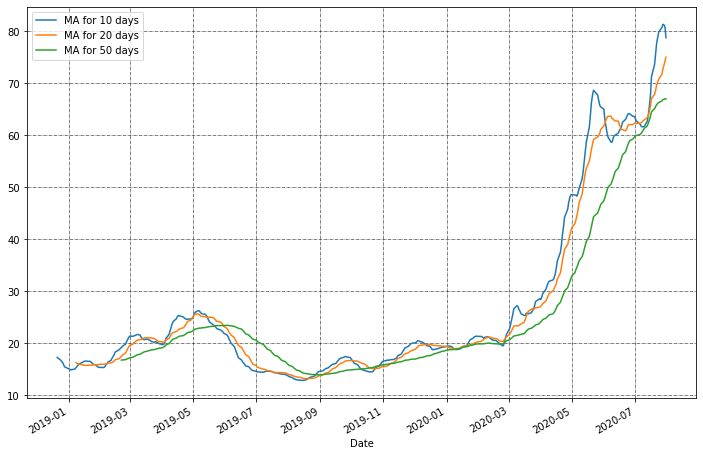

In [ ]:
mrna[['MA for 10 days',	'MA for 20 days',	'MA for 50 days']].plot(subplots=False,figsize=(12,8))
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)


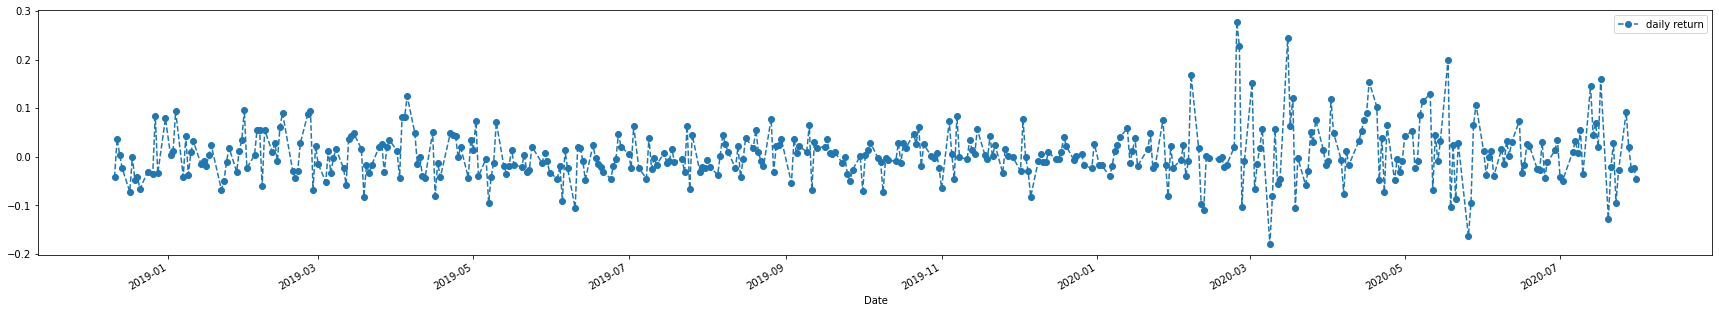

In [ ]:
mrna['daily return'] = mrna['adj close'].pct_change()
mrna['daily return'].plot(figsize=(30,5),legend=True,linestyle='--',marker='o')

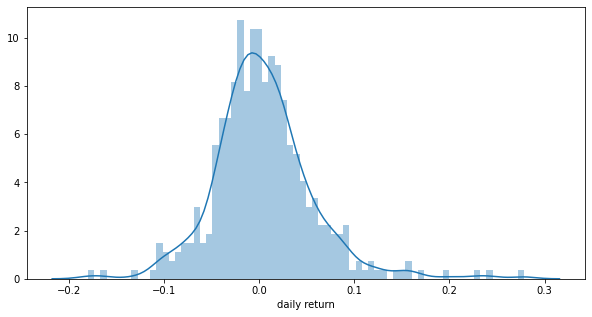

In [ ]:
fig = plt.subplots(figsize=(10,5))
sns.distplot(mrna['daily return'], bins=70)

In [ ]:
mrna.loc[mrna['daily return']>0.2]

,high,low,open,close,volume,adj close,MA for 10 days,MA for 20 days,MA for 50 days,daily return
Date,,,,,,,,,,
2020-02-25,26.549999,20.510000,22.150000,23.76,65001900,23.76,19.5355,20.39175,19.9421,0.278107
2020-02-26,29.980000,27.080000,29.049999,29.16,76444500,29.16,20.3165,20.73175,20.1563,0.227273
2020-03-16,27.799999,22.219999,23.760000,26.49,39850800,26.49,25.3350,24.07150,21.8601,0.243662


In [ ]:
mrna.loc[mrna['daily return']<-.15]

,high,low,open,close,volume,adj close,MA for 10 days,MA for 20 days,MA for 50 days,daily return
Date,,,,,,,,,,
2020-03-09,30.000000,24.160000,30.000000,24.290001,14124100,24.290001,27.220,23.37225,21.4837,-0.179669
2020-05-26,66.589996,57.049999,66.400002,57.709999,40332600,57.709999,67.768,59.69900,45.0738,-0.163623
